# Multi-Agent Financial Analysis System

**Team Members:** [Your Name(s) Here]  
**GitHub Repository:** [Your Team's GitHub Repository Link Here]

---

## Project Overview

This notebook implements a sophisticated multi-agent financial analysis system using LangChain and LangGraph. The system is designed to automate the process of investment research by coordinating multiple specialized AI agents to perform complex tasks end-to-end.

The core architecture follows a **Planner-Executor** model, augmented with a **Critique-Refinement** loop to ensure the quality and objectivity of the final analysis. This agentic approach moves beyond simple, scripted pipelines by enabling agents to reason, plan, delegate, and self-correct, mimicking the workflow of a human financial research team.

In [26]:
# Install necessary packages
# !pip install -q python-dotenv langchain-openai yfinance fredapi edgartools pytrends langgraph

In [27]:
# Import libraries and load environment variables
import os
import pprint
import json
import warnings
import requests
import re
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

from dotenv import load_dotenv
from fredapi import Fred
from edgar import Company, set_identity
from pytrends.request import TrendReq
import yfinance as yf

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain.tools import Tool
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator


In [28]:
# Load API keys from your .env file
load_dotenv()

# Check for the OpenAI API key
if not os.environ.get("OPENAI_API_KEY"):
    raise ValueError("OPENAI_API_KEY not found in environment variables. Please create a .env file.")

In [29]:

def clean_filing_content(text):
    """
    Clean the extracted filing content by removing XBRL/inline tags and normalizing whitespace.
    """
    # Remove all XBRL/inline tags (e.g., xbrli:shares, iso4217:USD, us-gaap:*, etc.)
    text = re.sub(r'\b(xbrli|us-gaap|dei|srt|aapl|intc):[^\s>]+', '', text)

    # Remove standalone tags like "P1Y", "c-1", "f-46", etc.
    text = re.sub(r'\b([A-Za-z]+-[0-9]+|[A-Za-z]+[0-9]+|[A-Z]{2,}[A-Za-z]*\d*)\b', '', text)

    # Remove dates in the format "YYYY-MM-DD" if they are standalone
    text = re.sub(r'(?<!\d)\d{4}-\d{2}-\d{2}(?!\d)', '', text)

    # Remove numbers like "0000050863" if they are standalone
    text = re.sub(r'(?<!\d)\d{8,}(?!\d)', '', text)

    # Remove extra whitespace and newlines
    text = re.sub(r'\s+', ' ', text).strip()

    return text

## Agent Design and Workflows

This system is built on a foundation of several key agentic workflow patterns that enable complex, autonomous behavior. The primary architectural choice is the **Planner-Executor** pattern, which separates the "thinking" from the "doing" to improve reliability and efficiency.


### 1. The Planner-Executor Workflow

The workflow begins with a clear separation of duties:

1.  **Planning Phase (`planner_node`):** A specialized **Planner Agent** is invoked first. Its sole responsibility is to create a strategic research plan. It performs a single, low-cost action—calling the `get_company_info` tool—to determine the company's market cap and sector. Based on this profile, it dynamically selects the appropriate set of tools for a deeper analysis and outputs its reasoning along with a structured plan (a JSON array of tool names).

2.  **Execution Phase (`executor_node`):** The plan is then passed to an **Executor Agent**. This agent's job is to mindlessly and efficiently execute the provided plan. Its internal protocol mandates that it **always** calls `read_notes_from_memory` first to gather historical context. Following that, it sequentially invokes each tool from the planner's list, gathering all the necessary data points before synthesizing an `initial_analysis`.

### 2. Specialist Agent Delegation (Prompt Chaining)

Within the Execution phase, the `executor_agent` demonstrates another key pattern: delegation to a specialist. When it needs to analyze news, it doesn't process the raw headlines itself. Instead, it calls the **`Financial_News_Analyst` tool**, which is a self-contained agent. This specialist agent performs an entire internal workflow (Ingest → Classify → Summarize) in a single call, returning a concise, high-level summary. This is an example of **Prompt Chaining**.

In [30]:
try:
    fred_api_key = os.environ.get("FRED_API_KEY")
    fred = Fred(api_key=fred_api_key)
except Exception:
    warnings.warn("FRED API key not found in Streamlit secrets. The economic data tool will be disabled.")
    fred = None

# --- Memory Component ---
MEMORY_FILE = "memory.json"

@tool
def read_notes_from_memory(ticker: str) -> list[str]:
    """
    Reads past analysis notes for a given stock ticker to provide context for a new analysis.
    Use this tool FIRST before any other tool to get historical context.
    """
    if not os.path.exists(MEMORY_FILE):
        return ["No past notes found for this ticker."]
    
    with open(MEMORY_FILE, 'r') as f:
        try:
            data = json.load(f)
            return data.get(ticker, ["No past notes found for this ticker."])
        except json.JSONDecodeError:
            return ["Memory file is empty or corrupted."]

@tool
def save_note_to_memory(ticker: str, note: str) -> str:
    """
    Saves a single, concise key takeaway from the latest analysis to memory for future reference.
    Use this tool LAST after the analysis is complete. The note should be a single sentence.
    """
    if not isinstance(note, str) or not note.strip():
        return "Error: Note must be a non-empty string."
        
    if os.path.exists(MEMORY_FILE) and os.path.getsize(MEMORY_FILE) > 0:
        with open(MEMORY_FILE, 'r') as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError:
                data = {}
    else:
        data = {}

    if ticker not in data:
        data[ticker] = []
    
    note_with_date = f"[**{datetime.now().strftime('%Y-%m-%d')}**] - {note.strip()}"
    data[ticker].append(note_with_date)
    data[ticker] = data[ticker][-3:]

    with open(MEMORY_FILE, 'w') as f:
        json.dump(data, f, indent=4)
        
    return f"Successfully saved note for {ticker}."

# --- Agentic Tools Definition ---

@tool
def get_company_info(ticker: str) -> dict:
    """Retrieves general information and key metrics for a given stock ticker."""
    stock = yf.Ticker(ticker)
    info = stock.info
    market_cap = info.get('marketCap')
    return {
        "longName": info.get('longName', 'N/A'),
        "marketCap": f"${market_cap:,}" if isinstance(market_cap, (int, float)) else 'N/A',
        "sector": info.get('sector', 'N/A'),
    }

@tool
def get_stock_news(ticker: str) -> list[str]:
    """Fetches the latest news headlines for a given stock ticker."""
    try:
        stock = yf.Ticker(ticker)
        news = stock.news
        if not news:
            return ["No recent news found."]
        return [
            article['content']['title'] 
            for article in news[:10]
            if 'content' in article and 'title' in article.get('content', {})
        ]
    except Exception as e:
        return [f"An error occurred: {e}"]


@tool
def search_specific_news(ticker: str, keywords: list[str]) -> list[str]:
    """
    Searches for news articles about a company from the last 30 days that contain specific keywords.
    Use this to find targeted information like 'partnerships', 'acquisitions', 'speculation', 'product launch', or 'regulatory approval'.
    The `keywords` argument should be a list of search terms.
    """
    try:
        api_key = os.environ.get("NEWS_API_KEY")
    except Exception:
        return ["Error: NewsAPI key not found"]

    # Calculate date 30 days ago
    date_from = (datetime.now() - timedelta(days=30)).strftime('%Y-%m-%d')
    
    # Format keywords for the API query
    query_keywords = " OR ".join(keywords)
    query = f'"{ticker}" AND ({query_keywords})'
    
    url = (f'https://newsapi.org/v2/everything?'
           f'q={query}&'
           f'from={date_from}&'
           f'sortBy=relevancy&'
           f'apiKey={api_key}')
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        articles = response.json().get('articles', [])
        
        if not articles:
            return [f"No specific news found for keywords '{', '.join(keywords)}' in the last 30 days."]
            
        # Return a list of the top 5 most relevant headlines
        return [article['title'] for article in articles[:5]]
        
    except Exception as e:
        return [f"An error occurred while fetching specific news: {e}"]
    
@tool
def get_price_summary(ticker: str) -> dict:
    """
    Retrieves a comprehensive price summary and key technical indicators for a stock.
    Provides the latest price, 52-week range, 50-day and 200-day moving averages, 
    and the 14-day Relative Strength Index (RSI) to understand the stock's trend and momentum.
    """
    try:
        stock = yf.Ticker(ticker)
        # Fetch 1 year of data to calculate all indicators
        hist = stock.history(period="1y")
        if hist.empty:
            return {"error": "Could not retrieve price history."}

        # --- Key Price Points ---
        latest_close = hist['Close'][-1]
        fifty_two_week_high = hist['High'].max()
        fifty_two_week_low = hist['Low'].min()

        # --- Trend Indicators (Moving Averages) ---
        # Calculate 50-day and 200-day moving averages
        ma_50 = hist['Close'].rolling(window=50).mean().iloc[-1]
        ma_200 = hist['Close'].rolling(window=200).mean().iloc[-1]
        
        # Determine trend based on MAs
        if latest_close > ma_50 and ma_50 > ma_200:
            trend = "Strong Uptrend"
        elif latest_close > ma_50 and latest_close > ma_200:
            trend = "Uptrend"
        elif latest_close < ma_50 and ma_50 < ma_200:
            trend = "Strong Downtrend"
        elif latest_close < ma_50 and latest_close < ma_200:
            trend = "Downtrend"
        else:
            trend = "Sideways/Consolidating"

        # --- Momentum Indicator (RSI) ---
        delta = hist['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        latest_rsi = rsi.iloc[-1]
        
        # Determine overbought/oversold condition
        if latest_rsi > 70:
            rsi_condition = "Overbought"
        elif latest_rsi < 30:
            rsi_condition = "Oversold"
        else:
            rsi_condition = "Neutral"

        return {
            "latest_price": f"${latest_close:.2f}",
            "52_week_high": f"${fifty_two_week_high:.2f}",
            "52_week_low": f"${fifty_two_week_low:.2f}",
            "trend_analysis": {
                "50_day_ma": f"${ma_50:.2f}",
                "200_day_ma": f"${ma_200:.2f}",
                "trend_conclusion": trend
            },
            "momentum_analysis": {
                "rsi_14_day": f"{latest_rsi:.2f}",
                "condition": rsi_condition
            }
        }
    except Exception as e:
        return {"error": f"Failed to calculate price summary: {e}"}

@tool
def get_financial_ratios(ticker: str) -> dict:
    """
    Calculates and returns key financial ratios for a given stock ticker.
    This provides insights into the company's valuation, profitability, and financial health.
    """
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        
        ratios = {
            "trailing_pe": info.get("trailingPE", "N/A"),
            "forward_pe": info.get("forwardPE", "N/A"),
            "price_to_book": info.get("priceToBook", "N/A"),
            "price_to_sales": info.get("priceToSalesTrailing12Months", "N/A"),
            "debt_to_equity": info.get("debtToEquity", "N/A"),
            "return_on_equity": info.get("returnOnEquity", "N/A"),
            "profit_margins": info.get("profitMargins", "N/A"),
        }
        
        return ratios
    except Exception as e:
        return {"error": f"Could not retrieve financial ratios: {e}"}

@tool
def get_analyst_ratings(ticker: str) -> dict:
    """
    Fetches the latest analyst ratings and price targets for a stock.
    This helps understand the consensus view from market professionals.
    """
    try:
        stock = yf.Ticker(ticker)
        recommendations = stock.recommendations
        
        if recommendations.empty:
            return {"message": "No analyst ratings found for this period."}
            
        # Get the most recent ratings
        latest_ratings = recommendations.tail(5)
        
        # Summarize ratings
        rating_counts = recommendations['strongBuy'].count() + recommendations['buy'].count()
        hold_counts = recommendations['hold'].count()
        sell_counts = recommendations['sell'].count() + recommendations['strongSell'].count()

        summary = {
            "period": recommendations.index.max().strftime('%Y-%m'),
            "buy_ratings": int(rating_counts),
            "hold_ratings": int(hold_counts),
            "sell_ratings": int(sell_counts),
            "latest_recommendations": latest_ratings[['firm', 'toGrade']].to_dict('records')
        }
        return summary
    except Exception as e:
        return {"error": f"Could not retrieve analyst ratings: {e}"}

@tool
def get_google_trends(keyword: str, timeframe: str = 'today 3-m') -> dict:
    """
    Fetches Google Trends data for a specific keyword over a given timeframe (e.g., 'today 3-m').
    This is useful for gauging public interest in a company or its products, especially for consumer brands.
    The keyword should ideally be the company's name (e.g., 'NVIDIA').
    """
    try:
        pytrends = TrendReq(hl='en-US', tz=360)
        pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='', gprop='')
        interest_over_time_df = pytrends.interest_over_time()

        if interest_over_time_df.empty:
            return {"message": "No Google Trends data found for this keyword."}
        
        avg_interest = interest_over_time_df[keyword].mean()
        peak_interest_date = interest_over_time_df[keyword].idxmax().strftime('%Y-%m-%d')
        
        return {
            "keyword": keyword,
            "average_interest_score": round(avg_interest, 2),
            "peak_interest_date": peak_interest_date,
            "comment": f"The average interest score is {round(avg_interest, 2)} out of 100 over the last 3 months."
        }
    except Exception as e:
        return {"error": f"Could not retrieve Google Trends data: {e}"}
    
@tool
def get_economic_data(series_id: str = 'GDP') -> dict:
    """
    Fetches the latest data for a given economic series from FRED.
    Use this to understand the broader economic context. For example, use series_id 'GDP' for GDP data.
    """
    if fred is None:
        return {"error": "FRED API key not configured. Cannot fetch economic data."}
    try:
        data = fred.get_series(series_id)
        latest_value = data.iloc[-1]
        latest_date = data.index[-1].strftime('%Y-%m-%d')
        return {
            "series": series_id,
            "latest_value": f"{latest_value:,.2f}",
            "latest_date": latest_date
        }
    except Exception as e:
        return {"error": f"Failed to fetch data for series {series_id}: {e}"}



@tool
def get_latest_filings(ticker: str, top_n: int = 1) -> list[dict]:
    """
    Fetch latest 10-K / 10-Q filings for the ticker.
    Returns a list of dicts with metadata and cleaned content.
    """
    try:
        # Identify to SEC
        set_identity("jagadeesch1981@gmail.com")
        company = Company(ticker.upper())
        filings = company.get_filings().filter(form=["10-K", "10-Q"])
        filings_df = filings.to_pandas()
        results = []
        for _, filing_row in filings_df.head(top_n).iterrows():
            filing_dict = filing_row.to_dict()
            # Prefer the filing's cik; fallback to company.cik if not present
            cik_raw = filing_row.get("cik") or getattr(company, "cik", None) or filing_row.get("company_info", {}).get("cik")
            if not cik_raw:
                results.append({"error": "No CIK available for this filing.", "filing_meta": filing_dict})
                continue
            cik = str(cik_raw).replace('-', '').zfill(10)  # zero-pad to 10 digits
            accession = str(filing_row.get("accession_number") or filing_row.get("accessionNo") or "").replace('-', '')
            primary_document = filing_row.get("primaryDocument") or filing_row.get("primary_doc") or ""
            # Construct canonical document URL
            document_url = None
            if accession and primary_document:
                document_url = f"https://www.sec.gov/Archives/edgar/data/{cik}/{accession}/{primary_document}"
            # Fallback URLs
            fallback_urls = []
            if filing_row.get("filing_href"):
                fallback_urls.append(filing_row.get("filing_href"))
            if filing_row.get("linkToFilingDetails"):
                fallback_urls.append(filing_row.get("linkToFilingDetails"))
            if filing_row.get("filing_url"):
                fallback_urls.append(filing_row.get("filing_url"))
            # Try primary constructed URL first, then fallbacks
            tried_urls = []
            headers = {"User-Agent": "jagadeesch1981@gmail.com"}
            response_text = None
            for url in ([document_url] if document_url else []) + fallback_urls:
                if not url:
                    continue
                tried_urls.append(url)
                try:
                    resp = requests.get(url, headers=headers, timeout=15)
                    resp.raise_for_status()
                    response_text = resp.text
                    used_url = url
                    break
                except requests.exceptions.HTTPError:
                    continue
                except requests.exceptions.RequestException as e:
                    results.append({
                        "error": f"Network error fetching filing: {e}",
                        "filing_meta": filing_dict,
                        "tried_urls": tried_urls
                    })
                    response_text = None
                    break
            if not response_text:
                results.append({
                    "error": f"Could not fetch filing document (404 or unavailable).",
                    "filing_meta": filing_dict,
                    "tried_urls": tried_urls
                })
                continue
            # Clean the text
            soup = BeautifulSoup(response_text, 'html.parser')
            # Remove all XBRL and XML tags
            for tag in soup.find_all(True, {"name": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"xlink": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"xbrli": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"us-gaap": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"dei": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"srt": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"aapl": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"intc": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"ixt": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"ixt-sec": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"xbrldi": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"xsi": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"iso4217": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"ecd": True}):
                tag.decompose()
            for tag in soup.find_all(True, {"xml": True}):
                tag.decompose()
            # Remove all <head> tags
            if soup.head:
                soup.head.decompose()
            # Get the cleaned text
            cleaned_text = soup.get_text(separator=' ', strip=True)
            # Further clean the text using regex
            cleaned_text = clean_filing_content(cleaned_text)
            results.append({
                "form_type": filing_dict.get("form"),
                "filed_at": str(filing_dict.get("filing_date") or filing_dict.get("filingDate")),
                "accession_number": accession,
                "url": used_url,
                "content": cleaned_text,
                "meta": filing_dict
            })
        if not results:
            return [{"error": f"No recent 10-K or 10-Q filings found for {ticker}."}]
        return results
    except Exception as e:
        return [{"error": f"Failed to fetch SEC filings for ticker {ticker}: {e}"}]
    
from langchain_core.prompts import MessagesPlaceholder
# --- Agent Creation Factory ---
def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])
    agent = create_openai_functions_agent(llm, tools, prompt)
    return AgentExecutor(agent=agent, tools=tools, verbose=False, return_intermediate_steps=True)




## Agent Functions and Capabilities

The agents in this system are designed with specific functions that align with the core requirements of an agentic AI.

### 1. Planning (`planner_agent`)
The system explicitly demonstrates planning capabilities. The **Planner Agent**'s primary function is to create a dynamic, context-aware research plan. It reasons about the company's profile (Penny Stock, Mid-Cap, etc.) and outputs a precise list of tools for the next agent to execute.

### 2. Dynamic Tool Use (`executor_agent`)
The **Executor Agent** showcases dynamic tool use. It is not hardcoded to run a fixed sequence of tools. Instead, it receives a plan as input and dynamically invokes the tools specified in that plan, allowing its behavior to adapt to the specific research task at hand.

### 3. Self-Reflection (`critic_agent`)
Self-reflection is implemented through the **Critic Agent**. After the `executor_agent` generates its initial analysis, the `critic_agent` is invoked to assess the quality of that output. It evaluates the analysis against predefined criteria: **Balance**, **Clarity**, and **Objectivity**, providing structured feedback for improvement.

### 4. Learning Across Runs (Memory Tools)
The system has a persistent memory implemented via the `read_notes_from_memory` and `save_note_to_memory` tools.
- At the **start** of every run, the executor agent is mandated to call `read_notes_from_memory`, ensuring it has historical context.
- At the **end** of the workflow, the `save_memory_node` generates a concise takeaway from the final report and saves it to a JSON file, allowing the system to learn and improve its context for future analyses of the same stock.

In [31]:
# --- Agent Definitions ---

def get_news_analyst_agent(llm: ChatOpenAI):
    """
    Defines a specialist agent that performs a multi-step news analysis chain.
    """
    # This agent only needs one tool: the ability to get raw news headlines.
    news_analyst_tools = [get_stock_news]
    
    # This detailed prompt IS the "Prompt Chain". It instructs the agent on the exact sequence of steps.
    news_analyst_prompt = (
        "You are an expert financial news analyst. Your goal is to produce a concise summary of the latest news sentiment.\n\n"
        "Follow this exact multi-step process:\n"
        "1. **Ingest:** First, use the `get_stock_news` tool to fetch the latest raw news headlines for the given stock ticker.\n"
        "2. **Classify & Analyze:** Internally, classify the sentiment of each headline (Positive, Negative, Neutral) and identify the key topics being discussed (e.g., earnings, partnerships, market trends).\n"
        "3. **Summarize:** Finally, synthesize your findings into a concise, 2-3 sentence summary that captures the overall sentiment and the most important news points.\n\n"
        "Your final output MUST be only the summary paragraph. Do not output the list of headlines or your classification details."
    )
    return create_agent(llm, news_analyst_tools, news_analyst_prompt)


def get_planner_agent(llm: ChatOpenAI):
    """
    An agent that creates a research plan based on company profile.
    It only decides WHICH tools to use, it does not execute them.
    """
    # This agent only needs one tool to do its job: get_company_info
    planner_tools = [get_company_info]
    
    planner_system_prompt = (
        "You are an expert financial planning agent. Your goal is to create a step-by-step research plan for a given company.\n\n"
        "1.  First, use the `get_company_info` tool to determine the company's market cap and sector.\n"
        "2.  Based on this information, select the appropriate tools from the following list that an executor agent should run: "
        "    --- MARKET CAP BASED PLANS ---\n\n"
        "    - **Penny Stock (<$50M):** Your scope is strictly limited. \n"
        "      **Required Tools:** `get_price_summary`, `Financial_News_Analyst`.\n"
        "      **Forbidden Tools:** Do not use `get_latest_filings` or `get_economic_data`.\n\n"

        "    - **Small-Cap ($50M - $2B):** These are growing companies requiring a balanced analysis. \n"
        "      **Required Tools:** `get_price_summary`, `Financial_News_Analyst`, `get_latest_filings`, `get_financial_ratios`.\n\n"

        "    - **Mid-Cap ($2B - $10B):** These are established companies. The analysis must focus on sustainable growth and profitability. \n"
        "      **Required Tools:** `get_price_summary`, `Financial_News_Analyst`, `get_financial_ratios`, `get_latest_filings`, `get_economic_data`.\n\n"

        "    - **Large-Cap (>$10B):** A comprehensive analysis is required. You must use all available tools for a complete picture.\n"
        "      **Required Tools:** `get_price_summary`, `Financial_News_Analyst`, `get_financial_ratios`, `get_latest_filings`, `get_economic_data`, `get_analyst_ratings`, and `get_google_trends` (if applicable to the sector).\n\n"
        
        "    --- SECTOR-BASED FOCUS ---\n\n"
        "    After selecting your tools, use the company's sector to refine your focus:\n"
        "    - **Technology/Healthcare:** Focus on innovation and competition. **Use `search_specific_news` with keywords like 'partnership', 'acquisition', and 'product launch'** to find key strategic moves.\n"
        "    - **Financials/Industrials:** Focus on balance sheet health, debt, and economic indicators like interest rates.\n"
        "    - **Consumer Cyclical/Defensive:** Focus on consumer sentiment and supply chain news.\n"
        "    - **Utilities/Energy/Real Estate:** Focus on debt, dividends, and interest rate sensitivity.\n\n"
        "Your final output MUST be a single, valid JSON object with two keys:\n"
        "1.  `reasoning`: A text containing your reason to choose all these tools and what to achieve in couple of lines.\n"
        "2.  `plan`: A JSON array of strings, where each string is the exact name of a tool to be executed.\n\n"
    )
    return create_agent(llm, planner_tools, planner_system_prompt)

def get_executor_agent(llm: ChatOpenAI):
    """
    An agent that executes a given research plan.
    It takes a plan and calls the tools in that plan.
    """
    # The specialist news agent needs to be created here for the executor's tool list
    news_analyst_agent = get_news_analyst_agent(llm)
    def run_news_agent(ticker: str):
        return news_analyst_agent.invoke({"input": ticker})
    news_analysis_tool = Tool(
        name="Financial_News_Analyst",
        func=run_news_agent,
        description="Provides a comprehensive summary of the latest news sentiment for a given stock ticker."
    )

    # This agent needs all the tools available for execution.
    executor_tools = [
        read_notes_from_memory,
        get_price_summary, 
        news_analysis_tool, 
        get_economic_data, 
        get_latest_filings,
        get_financial_ratios,
        get_analyst_ratings,
        get_google_trends,
        search_specific_news
    ]

    executor_system_prompt = (
        "You are an expert financial research executor. Your goal is to execute a given plan precisely.\n\n"
        "**Execution Protocol:**\n"
        "1.  **MANDATORY FIRST STEP:** Always begin by using the `read_notes_from_memory` tool to gather historical context for the ticker. This is a non-negotiable first action.\n"
        "2.  **Execute the Provided Plan:** After consulting memory, execute the tools listed in the user-provided plan, in the order they are given.\n\n"
        "Do not deviate from the plan or add extra tools. Your job is to execute, not to plan."
        "3.  **Synthesize Final Analysis:** After executing your chosen plan, combine all gathered information into a single, detailed analysis. This paragraph MUST be your final output.\n\n"
        "**Formatting Instructions:** Do not output markdown. Ensure your final output is a well-formatted, readable paragraph."
    )
    return create_agent(llm, executor_tools, executor_system_prompt)


def get_critic_agent(llm: ChatOpenAI):
    critic_prompt = ChatPromptTemplate.from_template(
        "You are a meticulous financial 'Critic' agent. Evaluate an analysis based on:\n"
        "1. **Balance:** Does it present both risks and opportunities?\n"
        "2. **Clarity:** Is the language clear and concise?\n"
        "3. **Objectivity:** Is the analysis data-driven?\n\n"
        "Provide short, bulleted feedback. If excellent, state 'No major changes needed'.\n\n"
        "Initial Analysis to Critique:\n{initial_analysis}"
    )
    return critic_prompt | llm

def get_refiner_agent(llm: ChatOpenAI):
    refiner_prompt = ChatPromptTemplate.from_template(
        "You are a 'Refiner' agent. Your task is to rewrite and improve an initial financial analysis based on a critique.\n\n"
        "Initial Analysis:\n{initial_analysis}\n\n"
        "Critique:\n{critique}\n\n"
        "Your Final, Rewritten Analysis:\n"
        "**Formatting instructions:** Your final output must be a well-structured report using markdown. "
        "Include a main header (e.g., '### <company name>'), use bolding for key metrics, and structure the content into clear, readable paragraphs with sub header (##### Company Overview, Growth Drivers, Profitability and Financial Health, Cost Structure and Investments, Risks and Competitive Landscape, Market Performance and Analyst Sentiment, Recommentation, Summary)." 
    )
    return refiner_prompt | llm



## Evaluation and Iteration

A key feature of this agentic system is its built-in mechanism for evaluation and iterative improvement, which is handled by the **Critique-Refinement** loop. This pattern ensures that the initial analysis does not go unchecked and is refined based on objective feedback before being presented as the final report.


The process follows a clear three-step pattern:

1.  **Generate (`executor_node`):** The **Executor Agent** first produces an `initial_analysis` based on the data it has gathered. This serves as the first draft.

2.  **Evaluate (`critic_node`):** The `initial_analysis` is then passed to the **Critic Agent**. This agent acts as an automated quality assurance step. It evaluates the draft against important criteria (e.g., Is it balanced? Does it present both risks and opportunities?) and produces a structured `critique`.

3.  **Refine (`refiner_node`):** Finally, both the `initial_analysis` and the `critique` are passed to the **Refiner Agent**. This agent's sole purpose is to rewrite and improve the initial draft by explicitly addressing the feedback from the critic. The output of this node is the polished `refined_analysis`, which becomes the final report.

This **Generate → Evaluate → Refine** cycle is a powerful form of self-correction that significantly enhances the quality, objectivity, and reliability of the system's output.

In [32]:
# --- Agent State ---
class AgentState(TypedDict):
    ticker: str
    plan: List[str] 
    reasoning: str
    research_steps: Annotated[List[dict], operator.add]
    initial_analysis: str
    critique: str
    refined_analysis: str
    memory_confirmation: str

# --- Agent Nodes ---
def planner_node(state):
    """Generates the research plan and reasoning."""
    planner_agent = get_planner_agent(ChatOpenAI(model="gpt-4.1-mini", temperature=0))
    # The agent now returns a JSON string
    result_json_string = planner_agent.invoke({"input": f"Create a plan for {state['ticker']}"})['output']
    
    # Parse the JSON string into a Python dictionary
    plan_data = json.loads(result_json_string)
    
    return {
        "reasoning": plan_data["reasoning"],
        "plan": plan_data["plan"]
    }

def executor_node(state):
    """Executes the research plan."""
    executor_agent = get_executor_agent(ChatOpenAI(model="gpt-4.1-mini", temperature=0))
    # Pass both the plan and the ticker to the executor
    result = executor_agent.invoke({
        "input": f"Execute the following plan for the ticker {state['ticker']}:\n\nPLAN: {state['plan']}"
    })
    return {"research_steps": result['intermediate_steps'], "initial_analysis": result['output']}

def critic_node(state):
    """Critiques the initial analysis."""
    critic_agent = get_critic_agent(ChatOpenAI(model="gpt-4.1-mini", temperature=0))
    critique_text = critic_agent.invoke({"initial_analysis": state["initial_analysis"]}).content
    # st.write(critique_text)
    return {"critique": critique_text}

def refiner_node(state):
    """Refines the analysis based on the critique."""
    refiner_agent = get_refiner_agent(ChatOpenAI(model="gpt-4.1-mini", temperature=0))
    refined_text = refiner_agent.invoke({
        "initial_analysis": state["initial_analysis"],
        "critique": state["critique"]
    }).content
    # st.write(refined_text)
    return {"refined_analysis": refined_text}

def save_memory_node(state):
    """Generates a key insight and saves it to memory."""
    llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
    
    # Use an LLM to generate a concise note from the refined analysis
    note_generation_prompt = ChatPromptTemplate.from_template(
        "You are a note-taking assistant. Based on the following financial analysis, generate a single, concise sentence that captures the most important takeaway. This will be saved for future reference.\n\n"
        "Analysis:\n{analysis}\n\n"
        "Your single-sentence takeaway:"
    )
    
    note_chain = note_generation_prompt | llm
    key_insight = note_chain.invoke({"analysis": state["refined_analysis"]}).content
    
    # Save the generated note to memory
    confirmation = save_note_to_memory.invoke({
        "ticker": state["ticker"],
        "note": key_insight
    })
    
    return {"memory_confirmation": confirmation}

# --- Graph Definition ---
def build_agentic_workflow():
    workflow = StateGraph(AgentState)

    # Add the new nodes
    workflow.add_node("planner", planner_node)
    workflow.add_node("executor", executor_node)
    workflow.add_node("critic", critic_node)
    workflow.add_node("refiner", refiner_node)
    workflow.add_node("save_memory", save_memory_node)

    # Define the new sequence of edges
    workflow.set_entry_point("planner")
    workflow.add_edge("planner", "executor")
    workflow.add_edge("executor", "critic")
    workflow.add_edge("critic", "refiner")
    workflow.add_edge("refiner", "save_memory")
    workflow.add_edge("save_memory", END)

    return workflow.compile()

In [33]:
from rich.markdown import Markdown
from rich.console import Console

In [34]:
console = Console()

In [ ]:
def run_workflow(ticker_symbol: str):
    """Executes the workflow and prints results."""
    print(f"📈 Starting analysis for {ticker_symbol}...\n")
    agent_workflow = build_agentic_workflow()
    inputs = {"ticker": ticker_symbol}
    final_report = "Analysis could not be generated."
    
    for event in agent_workflow.stream(inputs):
        for node_name, value in event.items():
            print(f"--- Running Node: {node_name.upper()} ---")
            if node_name == "planner":
                print("\nreasoning:")
                print(value.get('reasoning'))
                print("\nplan:")
                print(value.get('plan'))
            elif node_name == "executor":
                print("Tool Calls:")
                pprint.pprint(value.get('research_steps'))
                console.print("# Initial Analysis:")
                md_initial_analysis = Markdown(value.get('initial_analysis'))
                console.print(md_initial_analysis)
            elif node_name == "critic":
                print("Critique:")
                md_critique = Markdown(value.get('critique'))
                console.print(md_critique)
            elif node_name == "refiner":
                final_report = value.get("refined_analysis", final_report)
            elif node_name == "save_memory":
                print("Memory Update:")
                print(value.get('memory_confirmation'))
            print("-" * 40 + "\n")

    print("\n" + "="*25 + " FINAL REPORT " + "="*25)
    md_final_report = Markdown(final_report)
    console.print(md_final_report)
    print("="*64 + "\n\n✅ Workflow complete.")


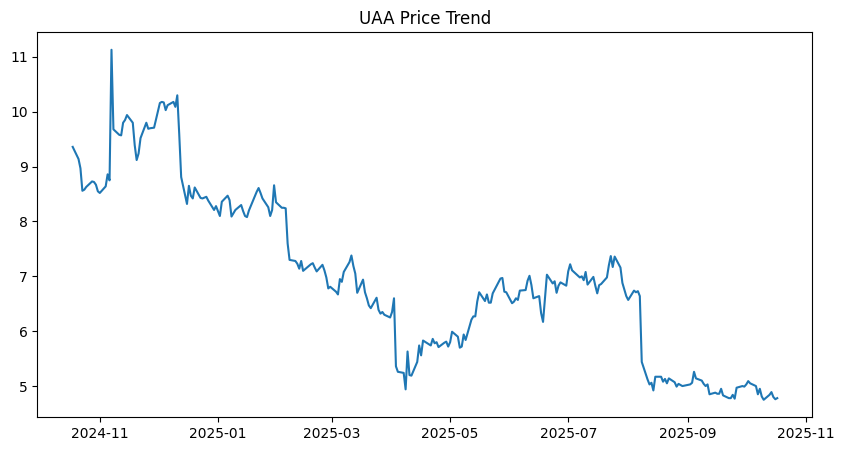

📈 Starting analysis for UAA...

--- Running Node: PLANNER ---

reasoning:
Under Armour, Inc. has a market cap of approximately $2.01 billion, placing it in the Mid-Cap category. This requires a focus on sustainable growth and profitability, so tools like get_price_summary, Financial_News_Analyst, get_financial_ratios, get_latest_filings, and get_economic_data are necessary. Since it is in the Consumer Cyclical sector, the analysis should emphasize consumer sentiment and supply chain news, so using search_specific_news with relevant keywords is important.

plan:
['get_price_summary', 'Financial_News_Analyst', 'get_financial_ratios', 'get_latest_filings', 'get_economic_data', 'search_specific_news']
----------------------------------------



/var/folders/x7/zz5b68y51xv5_26y13jhyzjh0000gn/T/ipykernel_22398/1108710819.py:142: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_close = hist['Close'][-1]


--- Running Node: EXECUTOR ---
Tool Calls:
[(AgentActionMessageLog(tool='read_notes_from_memory', tool_input={'ticker': 'UAA'}, log="\nInvoking: `read_notes_from_memory` with `{'ticker': 'UAA'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"ticker":"UAA"}', 'name': 'read_notes_from_memory'}}, response_metadata={'finish_reason': 'function_call'}, id='run-70bbde48-accf-48e8-aa56-1de03222f4d9')]),
  ['[**2025-10-18**] - Under Armour is undergoing a challenging but '
   'potentially rewarding turnaround, marked by declining sales and high debt '
   'yet supported by improving margins, strategic restructuring, and a '
   'cautiously optimistic market valuation anticipating recovery by 2025.',
   '[**2025-10-18**] - Under Armour faces significant near-term challenges '
   'with declining sales and high debt but shows potential for recovery '
   'through ongoing restructuring and financial management, warranting '
   'cautious investor mo

Under Armour (UAA) is currently facing significant challenges as reflected in its recent historical context, which 
highlights declining sales, high debt, and ongoing restructuring efforts aimed at a potential turnaround by 2025.  
The latest price summary shows the stock trading near its 52-week low at $4.78, with a strong downtrend indicated  
by the 50-day and 200-day moving averages and a neutral momentum condition (RSI 38.3). Recent news sentiment is    
predominantly negative, emphasizing weak demand globally and concerns about the slowing activewear market, though  
some analysts see a cautious opportunity for recovery in 2025. Financial ratios reveal a trailing P/E of about 21.7
and a forward P/E of 11.95, with a price-to-book ratio near 1.09 and price-to-sales at 0.39, indicating modest     
valuation. The company carries a high debt-to-equity ratio of 89.4, low return on equity (5.5%), and thin profit   
margins (1.98%), underscoring financial stress. The latest 10-Q filing for Q2 2025 details a 4.2% revenue decline  
year-over-year, with decreases in wholesale and direct-to-consumer sales, especially in footwear, though           
accessories saw growth. Gross margin improved slightly to 48.2%, helped by pricing and product mix, despite cost   
pressures. Operating expenses fell significantly due to lower litigation reserves and marketing spend. The company 
is actively executing a restructuring plan with expected charges of $140-$160 million through 2026 to improve      
operational efficiency. Liquidity remains supported by $911 million in cash and recent issuance of $400 million    
senior notes due 2030, intended to refinance existing debt. Economic context shows a stable GDP level of $30.5     
trillion as of Q1 2025, but no recent news on partnerships, acquisitions, product launches, or regulatory approvals
was found. Overall, Under Armour is navigating a difficult market environment with ongoing restructuring and       
financial management efforts, facing near-term headwinds but with potential for medium-term recovery if operational
improvements and market conditions stabilize. Investors should remain cautious given the company's high leverage,  
weak sales trends, and uncertain turnaround timeline.

----------------------------------------

--- Running Node: CRITIC ---
Critique:


 • Balance:                                                                                                        
    • Presents both risks (declining sales, high debt, negative sentiment, financial stress) and opportunities     
      (potential recovery by 2025, improved gross margin, restructuring efforts).                                  
    • Could slightly enhance the opportunity side by elaborating more on specific catalysts or market segments with
      growth potential.                                                                                            
 • Clarity:                                                                                                        
    • Language is generally clear and concise, with well-structured sentences and relevant financial metrics.      
    • Some sentences are dense with data; breaking them into shorter statements could improve readability.         
 • Objectivity:                                                                                                    
    • Analysis is data-driven, citing specific financial ratios, stock metrics, and recent filings.                
    • Uses neutral language without subjective bias, supporting conclusions with evidence.                         

Overall: No major changes needed.

----------------------------------------

--- Running Node: REFINER ---
----------------------------------------

--- Running Node: SAVE_MEMORY ---
Memory Update:
Successfully saved note for UAA.
----------------------------------------


========================= FINAL REPORT =========================


Under Armour (UAA)                                                 

                                                 Company Overview                                                  

Under Armour is currently navigating a challenging environment marked by declining sales, elevated debt levels, and
ongoing restructuring initiatives aimed at a potential turnaround by 2025. The company’s latest quarterly report   
(Q2 2025) highlights a 4.2% year-over-year revenue decline, driven primarily by decreases in wholesale and         
direct-to-consumer sales, particularly in the footwear segment. However, accessories sales showed growth, providing
a modest bright spot amid broader softness.                                                                        

                                                  Growth Drivers                                                   

Despite near-term headwinds, Under Armour is focusing on operational improvements and market repositioning. The    
company’s gross margin improved slightly to 48.2%, supported by strategic pricing adjustments and a favorable      
product mix. Additionally, restructuring efforts—including expected charges of $140-$160 million through 2026—are  
designed to enhance operational efficiency and reduce costs. While the activewear market is slowing globally, some 
analysts identify cautious recovery potential by 2025, especially if Under Armour can capitalize on growth in      
accessories and innovate within key segments.                                                                      

                                        Profitability and Financial Health                                         

Under Armour’s profitability remains under pressure, with a thin net profit margin of 1.98% and a return on equity 
(ROE) of 5.5%, reflecting ongoing financial stress. The company carries a high debt-to-equity ratio of 89.4,       
underscoring leverage concerns. Liquidity is supported by $911 million in cash and a recent issuance of $400       
million senior notes due 2030, which are intended to refinance existing debt and improve the capital structure.    

                                          Cost Structure and Investments                                           

Operating expenses declined significantly in the latest quarter, aided by lower litigation reserves and reduced    
marketing spend. These cost savings are part of the broader restructuring plan aimed at streamlining operations.   
However, the company continues to face cost pressures, which may limit margin expansion in the near term.          

                                          Risks and Competitive Landscape                                          

Key risks include continued weak demand in the activewear market, high leverage, and uncertainty around the timing 
and success of the turnaround plan. The absence of recent news on partnerships, acquisitions, or product launches  
suggests limited near-term catalysts. Competitive pressures from larger athletic apparel brands also remain a      
challenge.                                                                                                         

                                     Market Performance and Analyst Sentiment                                      

Under Armour’s stock is trading near its 52-week low at $4.78, with both the 50-day and 200-day moving averages    
indicating a strong downtrend. Momentum is neutral, with a Relative Strength Index (RSI) of 38.3. Recent news      
sentiment is predominantly negative, reflecting concerns about global demand and market slowdown. Valuation metrics
show a trailing P/E of 21.7, a forward P/E of 11.95, a price-to-book ratio of 1.09, and a price-to-sales ratio of  
0.39, suggesting modest valuation relative to peers.                                                               

                                                  Recommendation                           


✅ Workflow complete.


In [36]:
# --- Execute the Analysis ---
ticker_to_analyze = "UAA" 

import matplotlib.pyplot as plt

stock = yf.Ticker(ticker_to_analyze)
hist = stock.history(period='1y')
plt.figure(figsize=(10,5))
plt.plot(hist['Close'])
plt.title(f'{ticker_to_analyze} Price Trend')
plt.show()

run_workflow(ticker_to_analyze)

## Conclusion and Future Work

### Conclusion

This project successfully demonstrates the power of a multi-agent system for complex financial analysis. By separating the roles of planning, execution, and critique, the system produces a nuanced and objective report that dynamically adapts its research strategy based on the company's profile. The successful implementation of memory allows the agent to build context over time, making it a truly "learning" system. The final output for the test ticker (e.g., UAA) showcases the end-to-end workflow, from initial data gathering to a polished, refined analysis.

### Future Work

While the current system is robust, there are several avenues for future enhancement:

1.  **Human-in-the-Loop Feedback:** The plan generated by the `planner_agent` could be presented to a human user for approval or modification before being passed to the executor. This would add a layer of expert oversight.

2.  **Deeper Financial Analysis Tools:** New tools could be developed to parse financial statements (10-K/10-Q) in more detail, extracting specific tables and calculating trends in metrics like revenue, net income, and free cash flow over multiple quarters.

3.  **Visual Data Integration:** The final report could be enhanced by programmatically generating and including visual charts for financial trends or stock performance directly within the analysis.

4.  **"Analyst Verdict" Scorecard:** A final agent could be added to the workflow to score the company on key factors (e.g., Valuation, Financial Health, Momentum) and produce a quick, "at-a-glance" scorecard, providing an even more digestible summary for the end-user.